探索固相之间的界面反应, 探索反应能与混合比例之间的关系

使用Mp-API获得化合物的能量;

In [1]:
from pymatgen.ext.matproj import MPRester
from pymatgen.analysis.interface_reactions import InterfacialReactivity
from pymatgen.analysis.phase_diagram import PhaseDiagram, GrandPotentialPhaseDiagram 
from pymatgen import Composition, Element
%matplotlib inline

In [2]:
mpr = MPRester()

## 生成有关反应物生成物及其混合比例的`拟二元稳定相图`(pseudo-binary phase stability diagram)

从反应物字符串创建组成对象

In [3]:
reactant1, reactant2 = 'LiCoO2','Li3PS4' 
comp1, comp2 = Composition(reactant1), Composition(reactant2)
%C comp1; comp2

     comp1             comp2     
----------------  ---------------
Comp: Li1 Co1 O2  Comp: Li3 P1 S4


考虑反应系统与元素氛(reservoir)接触的情况;  

In [4]:
grand = True 
if grand:
    # 元素氛中元素
    open_el = 'Co'
    # 与纯物质的相对化学势(Must be non-positive)
    relative_mu = -1

搜集化学系统中涉及的所有元素

In [5]:
elements = [e.symbol for e in comp1.elements + comp2.elements]
if grand:
    elements.append(open_el)
elements = list(set(elements)) # Remove duplicates
elements

['P', 'S', 'O', 'Li', 'Co']

从化学体系获取结构: 时间稍长

In [6]:
entries = mpr.get_entries_in_chemsys(elements)#len(entries)=624

使用条目对象创建相图的算法基础:  
[Li-Fe-P-O2 Phase Diagram from First Principles Calculations](https://pubs.acs.org/doi/abs/10.1021/cm702327g);  
[Thermal stabilities of delithiated olivine MPO4 (M=Fe, Mn) cathodes investigated using first principles calculations](https://www.sciencedirect.com/science/article/pii/S1388248110000123);

In [9]:
# 相图对象
pd = PhaseDiagram(entries)

In [10]:
open_el

'Co'

In [11]:
# 对于开放系统绘制巨势相图
if grand:
    mu = pd.get_transition_chempots(Element(open_el))[0]  #获取纯物质(过渡态)的化学势, 'Co'?
    chempots = {open_el: relative_mu + mu}    # 设置化学氛的化学势(reservoir) 
    gpd = GrandPotentialPhaseDiagram(entries, chempots) # 构建巨势相图
    # 创建界面反应对象
    interface = InterfacialReactivity(
        comp1, comp2, gpd, norm=True, include_no_mixing_energy=True, pd_non_grand=pd, use_hull_energy=False)
else:
    interface = InterfacialReactivity(
        comp1, comp2, pd, norm=True, include_no_mixing_energy=False, pd_non_grand=None, use_hull_energy=False)

绘制反应能和混合比例之间的关系曲线

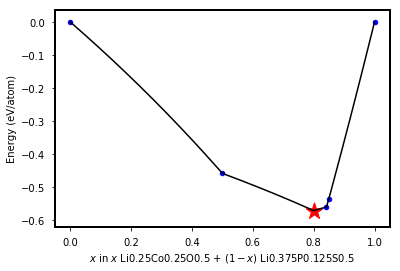

In [12]:
plt = interface.plot()

## 收集每个点处的关键反应(critical reaction)

In [14]:
from collections import OrderedDict
from pandas import DataFrame

# 将每个关键反应保存在列表当中
critical_rxns = [ OrderedDict( [("mixing ratio", round(ratio, 4)),
                                ("reaction energy (eV/atom)", round(energy, 4)),
                                ("reaction", rxn)])
                  for _, ratio, energy, rxn, energy2, in interface.get_kinks()]

In [15]:
# 将列表转化成 DF对象
DataFrame(critical_rxns)

,mixing ratio,reaction energy (eV/atom),reaction
0,0.0000,0.0000,Li3PS4 -> Li3PS4
1,0.5000,-0.4584,Li3PS4 + 2 LiCoO2 -> 0.5 Co + Li2S + 1.5 CoS2 ...
2,0.8000,-0.5710,Li3PS4 + 8 LiCoO2 -> 8 Co + 3 Li2SO4 + Li2S + ...
3,0.8421,-0.5601,Li3PS4 + 10.67 LiCoO2 -> 10.67 Co + 1.333 Li2O...
4,0.8500,-0.5350,Li3PS4 + 11.33 LiCoO2 -> 10.67 Co + 0.6667 Li5...
5,1.0000,-0.0000,LiCoO2 -> LiCoO2


反应方程(reaction equations)是反应对象(Reaction),适用于所有的结构分析

In [16]:
rxn = critical_rxns[2]["reaction"]
print(type(rxn))
print(rxn)

<class 'pymatgen.analysis.reaction_calculator.Reaction'>
Li3PS4 + 8 LiCoO2 -> 8 Co + 3 Li2SO4 + Li2S + Li3PO4


## 使用MP-API直接获得反应信息

In [17]:
# Get interface reaction information for reactants LiCoO2 and Li3PS4 in open system to Co.
kinks_from_API = mpr.get_interface_reactions('LiCoO2','Li3PS4', open_el='Co', relative_mu=-1)

In [18]:
# Get inforamtion for the second critical reaction.
kinks_from_API[1]

{'ratio': 0.5000000000000001,
 'energy': -0.45837463535714296,
 'rxn': Li3PS4 + 2 LiCoO2 -> 0.5 Co + Li2S + 1.5 CoS2 + Li3PO4,
 'energy_per_mol_rxn_kJmol': -619.1697988675436}

自计算和MP-API使用的数据来源一致, 结果也应一致

In [19]:
critical_rxns_API = [   OrderedDict([
                        ("mixing ratio", round(reaction['ratio'], 4)),
                        ("reaction energy (eV/atom)", round(reaction['energy'], 4)),
                        ("reaction", reaction['rxn'])])
                        for reaction in kinks_from_API        ]

In [20]:
DataFrame(critical_rxns_API)

,mixing ratio,reaction energy (eV/atom),reaction
0,0.0000,0.0000,Li3PS4 -> Li3PS4
1,0.5000,-0.4584,Li3PS4 + 2 LiCoO2 -> 0.5 Co + Li2S + 1.5 CoS2 ...
2,0.8000,-0.5710,0.3333 Li3PS4 + 2.667 LiCoO2 -> 2.667 Co + Li2...
3,0.8421,-0.5601,0.75 Li3PS4 + 8 LiCoO2 -> 8 Co + Li2O + 3 Li2S...
4,0.8500,-0.5350,1.5 Li3PS4 + 17 LiCoO2 -> 16 Co + Li5CoO4 + 6 ...
5,1.0000,-0.0000,LiCoO2 -> LiCoO2
